In [26]:
import tensorflow as tf
import tensorlayer as tl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import svm, decomposition, pipeline
from sklearn.model_selection import GridSearchCV, KFold
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from datetime import datetime

%matplotlib inline

### Data Reading and Preprocessing

In [27]:
trainData = pd.read_csv('train.csv')
trainLabels = trainData['label'].as_matrix()
trainImages = trainData.iloc[:, 1:].as_matrix()

testData = pd.read_csv('test.csv')
testImages = testData.as_matrix()


In [28]:
trainImages = trainImages / 255
testImages = testImages / 255

In [29]:
def writeOutput(prediction, filename):
    with open(filename, 'w') as fd:
        fd.write("ImageId,Label" + '\n')
        for i in range(len(prediction)):
            fd.write(str(i + 1) + "," + str(prediction[i]) + '\n')

### Linear SVC (One-Against-Rest) Multiclass with C = 1

In [5]:
starttime = datetime.now()

svc = svm.LinearSVC(loss = 'hinge', multi_class='ovr')
svc.fit(trainImages, trainLabels)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

prediction = svc.predict(testImages)

writeOutput(prediction, 'LinearSVMPredictionOVR.csv')

Total time to train:  0:00:17.269134


In [6]:
svc.score(trainImages, trainLabels)

0.93354761904761907

A lot faster but only achieves 91.60% accuracy on Kaggle

### Linear SVC (One-Against-One) Multiclass with C = 1

In [303]:
starttime = datetime.now()

svc = svm.SVC(kernel = 'linear', decision_function_shape = 'ovo')
svc.fit(trainImages, trainLabels)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

prediction = svc.predict(testImages)

writeOutput(prediction, 'LinearSVMPredictionOVO.csv')

Total time to train:  0:02:47.164286


In [304]:
svc.score(trainImages, trainLabels)

0.97723809523809524

Achieves 93.2229% accuracy on Kaggle

### RBF SVC (One-Against-One) Multiclass with C = 1

In [305]:
starttime = datetime.now()

svc = svm.SVC(decision_function_shape = 'ovo')
svc.fit(trainImages, trainLabels)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

prediction = svc.predict(testImages)

writeOutput(prediction, 'rbfSVMPrediction.csv')

Total time to train:  0:05:11.225662


In [306]:
svc.score(trainImages, trainLabels)

0.9405

Achieves 93.60% accuracy on Kaggle

### SVC (One-Against-One) Multiclass with C = 1 with PCA (20 Dimensions)

In [307]:
starttime = datetime.now()

# Fit PCA on the training set and take the first 20 principal components
pca = decomposition.PCA(n_components = 20)
# Reduce dimensions
reducedTrainImages = pca.fit_transform(trainImages)
svc = svm.SVC(decision_function_shape = 'ovo')
# Train SVC on reduced dimenions
svc.fit(reducedTrainImages, trainLabels)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

# Reduce the dimensions of test images
reducedTestImages = pca.transform(testImages)
prediction = svc.predict(reducedTestImages)

writeOutput(prediction, 'pcaSVMPrediction.csv')

Total time to train:  0:00:18.377148


In [308]:
svc.score(reducedTrainImages, trainLabels)

0.98876190476190473

Achieves 97.586% accuracy on Kaggle

### SVC (One-VS-One) Multiclass with C selected by 10-Fold CV with PCA (20 Dimensions)

In [309]:
starttime = datetime.now()

# Fit PCA on the training set and take the first 20 principal components
pca = decomposition.PCA(n_components = 20)
# Reduce dimensions
reducedTrainImages = pca.fit_transform(trainImages)

param_grid = {'C': [1.0, 2.0, 3.0, 4.0, 5.0]}
svc = GridSearchCV(svm.SVC(decision_function_shape = 'ovo'), param_grid = param_grid, cv = KFold(10))
svc.fit(reducedTrainImages, trainLabels)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

prediction = svc.predict(reducedTestImages)
writeOutput(prediction, 'pcaSVMPredictionCV.csv')

print("The best parameter value C is:", svc.best_estimator_)

Total time to train:  0:18:11.058782
The best parameter value C is: SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [310]:
svc.score(reducedTrainImages, trainLabels)

0.99771428571428566

Achieves 97.829% accuracy on Kaggle

### Multilayer Perceptron

In [30]:
trainLabelsOneHot = to_categorical(trainLabels)

In [31]:
starttime = datetime.now()

np.random.seed(1)

model = Sequential()
model.add(Dense(128, input_dim = trainImages.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(trainLabelsOneHot.shape[1]))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and Adam as the optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

print("Training...")
model.fit(trainImages, trainLabelsOneHot, epochs=500, batch_size=500, verbose=2)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

print("Generating test predictions...")
prediction = model.predict_classes(testImages, verbose=0)

writeOutput(prediction, 'mlpPrediction.csv')

Training...
Epoch 1/500
2s - loss: 2.1814 - acc: 0.2177
Epoch 2/500
1s - loss: 1.7028 - acc: 0.4516
Epoch 3/500
1s - loss: 1.2733 - acc: 0.6018
Epoch 4/500
1s - loss: 1.0153 - acc: 0.6828
Epoch 5/500
1s - loss: 0.8575 - acc: 0.7346
Epoch 6/500
1s - loss: 0.7585 - acc: 0.7625
Epoch 7/500
1s - loss: 0.6818 - acc: 0.7911
Epoch 8/500
1s - loss: 0.6220 - acc: 0.8094
Epoch 9/500
1s - loss: 0.5784 - acc: 0.8244
Epoch 10/500
1s - loss: 0.5395 - acc: 0.8377
Epoch 11/500
1s - loss: 0.5172 - acc: 0.8447
Epoch 12/500
1s - loss: 0.4906 - acc: 0.8534
Epoch 13/500
1s - loss: 0.4704 - acc: 0.8630
Epoch 14/500
1s - loss: 0.4534 - acc: 0.8655
Epoch 15/500
1s - loss: 0.4347 - acc: 0.8710
Epoch 16/500
1s - loss: 0.4199 - acc: 0.8785
Epoch 17/500
1s - loss: 0.4069 - acc: 0.8810
Epoch 18/500
1s - loss: 0.3902 - acc: 0.8854
Epoch 19/500
1s - loss: 0.3807 - acc: 0.8909
Epoch 20/500
1s - loss: 0.3750 - acc: 0.8918
Epoch 21/500
1s - loss: 0.3636 - acc: 0.8944
Epoch 22/500
1s - loss: 0.3510 - acc: 0.8973
Epoch 2

Achieves 97.443% accuracy on Kaggle

### Convolution Neural Network

In [137]:
trainImagesCNN = trainImages.reshape(trainImages.shape[0], 28, 28, 1)
testImagesCNN = testImages.reshape(testImages.shape[0], 28, 28, 1)
trainLabelsOneHot = to_categorical(trainLabels)

In [138]:
starttime = datetime.now()

np.random.seed(1)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(trainLabelsOneHot.shape[1], activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 0.0001), metrics=['accuracy'])
# Fit the model
model.fit(trainImagesCNN, trainLabelsOneHot, epochs=500, batch_size=500, verbose=2)

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

# CNN
print("Generating test predictions...")
prediction = model.predict_classes(testImagesCNN, verbose=0)

writeOutput(prediction, 'cnnPredictionSmall.csv')

Epoch 1/500
5s - loss: 1.9513 - acc: 0.3399
Epoch 2/500
4s - loss: 0.8542 - acc: 0.7238
Epoch 3/500
4s - loss: 0.4928 - acc: 0.8439
Epoch 4/500
4s - loss: 0.3672 - acc: 0.8870
Epoch 5/500
4s - loss: 0.2970 - acc: 0.9065
Epoch 6/500
4s - loss: 0.2540 - acc: 0.9225
Epoch 7/500
4s - loss: 0.2200 - acc: 0.9341
Epoch 8/500
4s - loss: 0.2004 - acc: 0.9388
Epoch 9/500
4s - loss: 0.1816 - acc: 0.9443
Epoch 10/500
4s - loss: 0.1632 - acc: 0.9507
Epoch 11/500
4s - loss: 0.1544 - acc: 0.9530
Epoch 12/500
4s - loss: 0.1447 - acc: 0.9560
Epoch 13/500
4s - loss: 0.1352 - acc: 0.9587
Epoch 14/500
4s - loss: 0.1278 - acc: 0.9615
Epoch 15/500
4s - loss: 0.1220 - acc: 0.9634
Epoch 16/500
4s - loss: 0.1170 - acc: 0.9649
Epoch 17/500
4s - loss: 0.1049 - acc: 0.9689
Epoch 18/500
4s - loss: 0.1036 - acc: 0.9688
Epoch 19/500
4s - loss: 0.1004 - acc: 0.9701
Epoch 20/500
4s - loss: 0.0917 - acc: 0.9724
Epoch 21/500
4s - loss: 0.0881 - acc: 0.9739
Epoch 22/500
4s - loss: 0.0879 - acc: 0.9733
Epoch 23/500
4s - l

Achieves 99.571% accuracy on Kaggle

### Convolution Neural Network (New Training Data Created by Convolving and Shifting Training Images)

In [139]:
trainImagesCNN = trainImages.reshape(trainImages.shape[0], 28, 28, 1)
testImagesCNN = testImages.reshape(testImages.shape[0], 28, 28, 1)
trainLabelsOneHot = to_categorical(trainLabels)

In [141]:
starttime = datetime.now()

datagen = ImageDataGenerator(rotation_range = 20, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')

np.random.seed(1)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(trainLabelsOneHot.shape[1], activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 0.0001), metrics=['accuracy'])
# Fit the model
model.fit_generator(datagen.flow(trainImagesCNN, trainLabelsOneHot, batch_size = 500), 
                    steps_per_epoch = trainImagesCNN.shape[0] / 500 * 2, epochs = 500, verbose = 2)

endtime = datetime.now()

print("Total time to train: ", endtime - starttime)

# CNN without
print("Generating test predictions...")
prediction = model.predict_classes(testImagesCNN, verbose=0)

writeOutput(prediction, 'cnnPredictionImgPreprocess.csv')

Epoch 1/500
13s - loss: 2.1852 - acc: 0.1954
Epoch 2/500
12s - loss: 1.5025 - acc: 0.4739
Epoch 3/500
12s - loss: 1.0359 - acc: 0.6519
Epoch 4/500
13s - loss: 0.7986 - acc: 0.7415
Epoch 5/500
13s - loss: 0.6597 - acc: 0.7906
Epoch 6/500
13s - loss: 0.5694 - acc: 0.8207
Epoch 7/500
13s - loss: 0.5067 - acc: 0.8429
Epoch 8/500
13s - loss: 0.4511 - acc: 0.8614
Epoch 9/500
13s - loss: 0.4200 - acc: 0.8717
Epoch 10/500
13s - loss: 0.3827 - acc: 0.8828
Epoch 11/500
12s - loss: 0.3560 - acc: 0.8906
Epoch 12/500
13s - loss: 0.3392 - acc: 0.8955
Epoch 13/500
13s - loss: 0.3208 - acc: 0.9024
Epoch 14/500
13s - loss: 0.3040 - acc: 0.9069
Epoch 15/500
13s - loss: 0.2887 - acc: 0.9122
Epoch 16/500
13s - loss: 0.2755 - acc: 0.9168
Epoch 17/500
13s - loss: 0.2630 - acc: 0.9199
Epoch 18/500
13s - loss: 0.2561 - acc: 0.9228
Epoch 19/500
13s - loss: 0.2414 - acc: 0.9272
Epoch 20/500
13s - loss: 0.2371 - acc: 0.9289
Epoch 21/500
13s - loss: 0.2235 - acc: 0.9319
Epoch 22/500
13s - loss: 0.2165 - acc: 0.93

Achieves 99.657% accuracy on Kaggle

### Appendices

#### View Image in Training Set

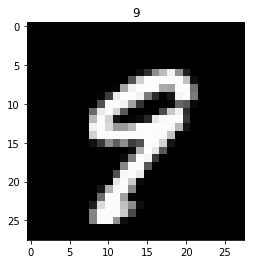

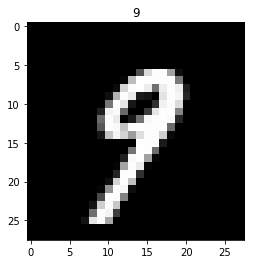

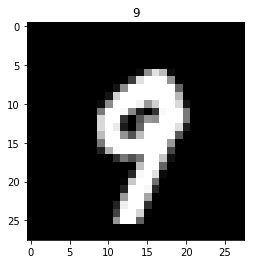

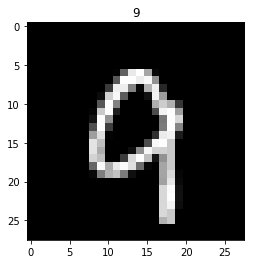

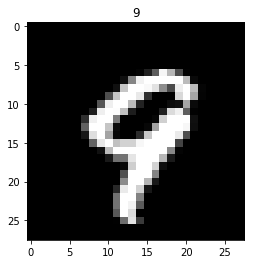

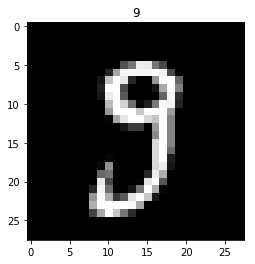

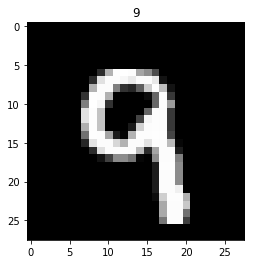

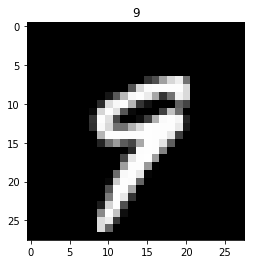

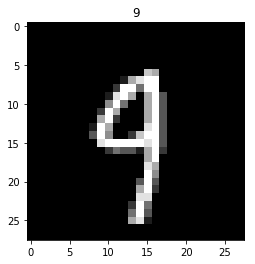

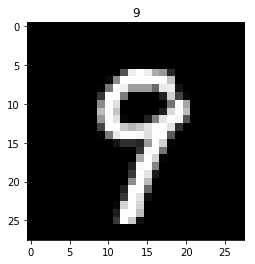

In [32]:
# Show first ten handwritten digit 9
for idx in np.where(trainLabels == 9)[0][:10]:
    img=trainImages[idx]
    img=img.reshape((28,28))
    plt.imshow(img,cmap='gray')
    plt.title(trainLabels[idx])
    plt.show()
    plt.close()

#### PCA - Reduce Training Set to Two Dimensions

In [7]:
# Fit PCA on the training set and take the first 2 principal components
pca2 = decomposition.PCA(n_components = 2)
# Reduce dimensions
pcaTrainImages = pca2.fit_transform(trainImages)

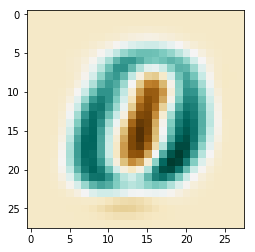

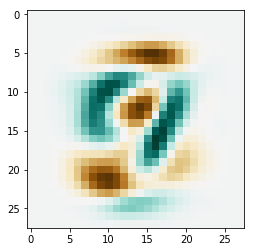

In [77]:
# Visualising First Two Principal Components

# First principal component - BlueGreen = positive, brown = negative
img = pca2.components_[0].reshape((28, 28))
plt.imshow(img, cmap='BrBG')
plt.show()
plt.close()

# Second principal component - BlueGreen = positive, brown = negative
img = pca2.components_[1].reshape((28, 28))
plt.imshow(img, cmap='BrBG')
plt.show()
plt.close()

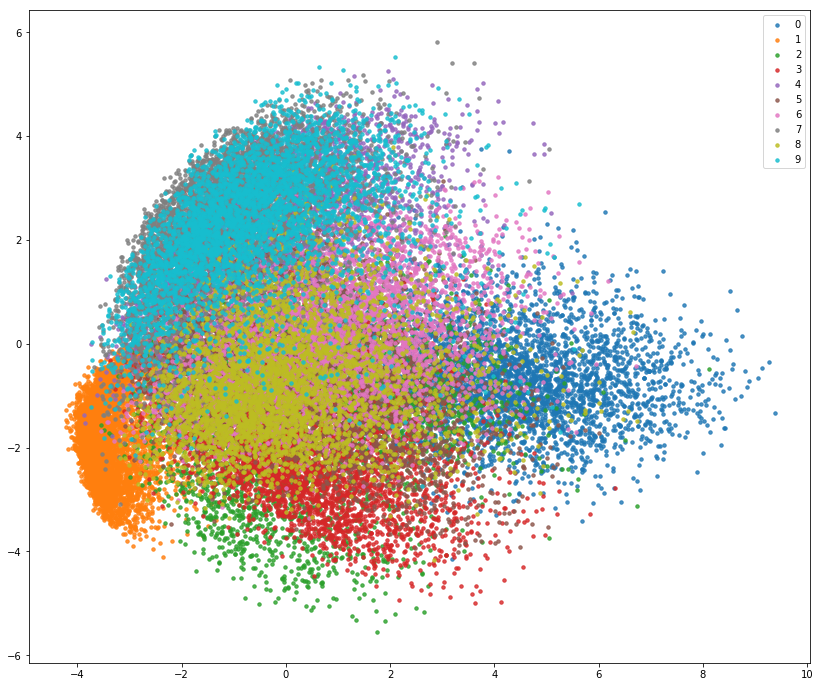

In [283]:
# Scatterplot of the Training Data Projections using First Two Principal Components

plt.figure(figsize = (14, 12))
for i in range(10):
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], c = plt.cm.Vega10.colors[i], label = i, alpha = 0.8, s = 12)
plt.legend(loc = 'upper right')
plt.show()
plt.close()

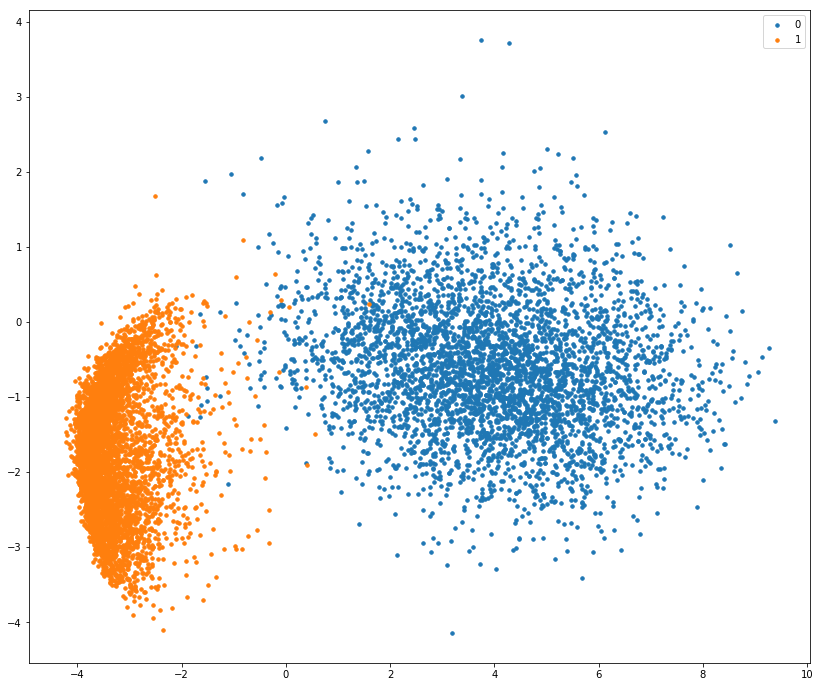

In [286]:
# Only plot class 0 vs class 1

plt.figure(figsize = (14, 12))
for i in [0, 1]:
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], c = plt.cm.Vega10.colors[i], label = i, s = 12)
plt.legend(loc = 'upper right')
plt.show()
plt.close()

In [288]:
# SVM of Class 0 vs Class 1 (linear SVM)

idx = (trainLabels == 0) | (trainLabels == 1)

starttime = datetime.now()

svc = svm.SVC(kernel = 'linear')
svc.fit(pcaTrainImages[idx, :], trainLabels[idx])

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

Total time to train:  0:00:00.051038


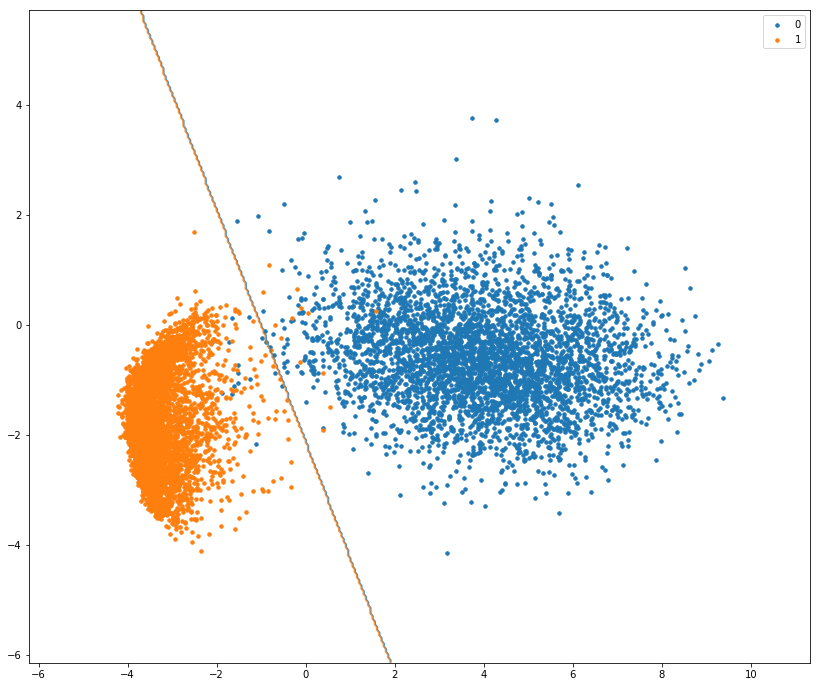

In [289]:
# Visualising Linear decision boundary

plt.figure(figsize = (14, 12))

h = 0.05
# create a mesh to plot in
x_min, x_max = pcaTrainImages[idx, 0].min() - 2, pcaTrainImages[idx, 0].max() + 2
y_min, y_max = pcaTrainImages[idx, 1].min() - 2, pcaTrainImages[idx, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, 2, colors = (plt.cm.Vega10.colors[0], plt.cm.Vega10.colors[1]), alpha=0.8)
for i in [0, 1]:
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], cmap = plt.cm.Vega10, label = i, s = 12)

#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title(titles[i])
plt.legend(loc = 'upper right')

plt.show()
plt.close()

In [290]:
# SVM of Class 0 vs Class 1 (RBF Kernel)

idx = (trainLabels == 0) | (trainLabels == 1)

starttime = datetime.now()

svc = svm.SVC()
svc.fit(pcaTrainImages[idx, :], trainLabels[idx])

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

Total time to train:  0:00:00.203661


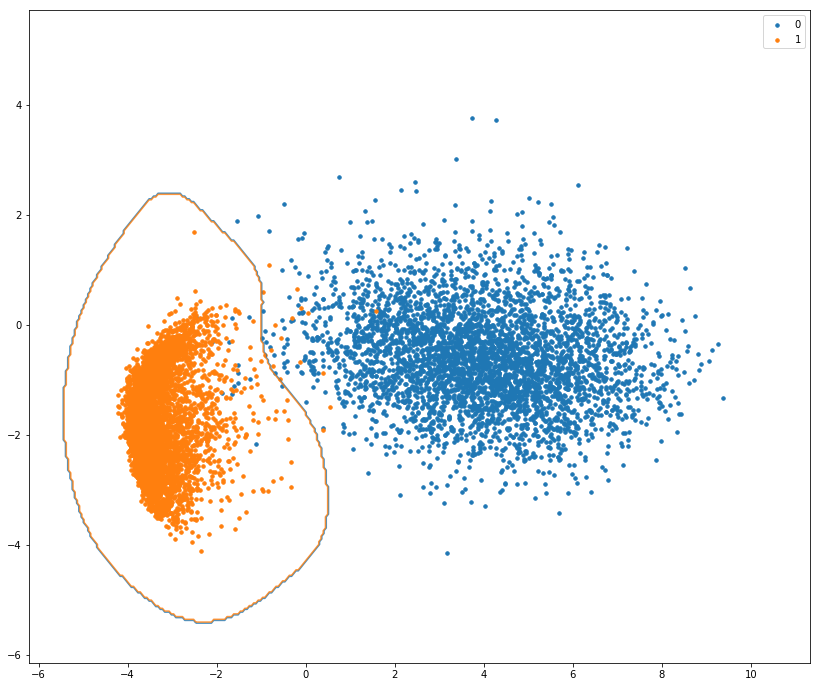

In [291]:
# Visualising non-Linear decision boundary

plt.figure(figsize = (14, 12))

h = 0.05
# create a mesh to plot in
x_min, x_max = pcaTrainImages[idx, 0].min() - 2, pcaTrainImages[idx, 0].max() + 2
y_min, y_max = pcaTrainImages[idx, 1].min() - 2, pcaTrainImages[idx, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, 2, colors = (plt.cm.Vega10.colors[0], plt.cm.Vega10.colors[1]), alpha=0.8)
for i in [0, 1]:
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], cmap = plt.cm.Vega10, label = i, s = 12)

#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title(titles[i])
plt.legend(loc = 'upper right')

plt.show()
plt.close()

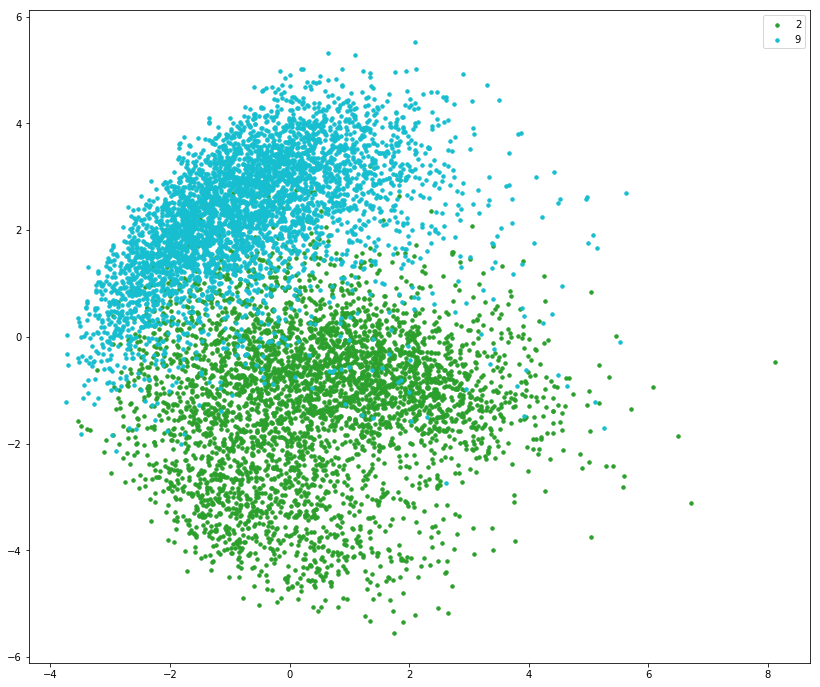

In [292]:
# Only plot class 2 vs class 9

plt.figure(figsize = (14, 12))
for i in [2, 9]:
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], c = plt.cm.Vega10.colors[i], label = i, s = 12)
plt.legend(loc = 'upper right')
plt.show()
plt.close()

In [293]:
# SVM of Class 2 vs Class 9 (linear SVM)

idx = (trainLabels == 2) | (trainLabels == 9)

starttime = datetime.now()

svc = svm.SVC(kernel = 'linear')
svc.fit(pcaTrainImages[idx, :], trainLabels[idx])

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

Total time to train:  0:00:00.952291


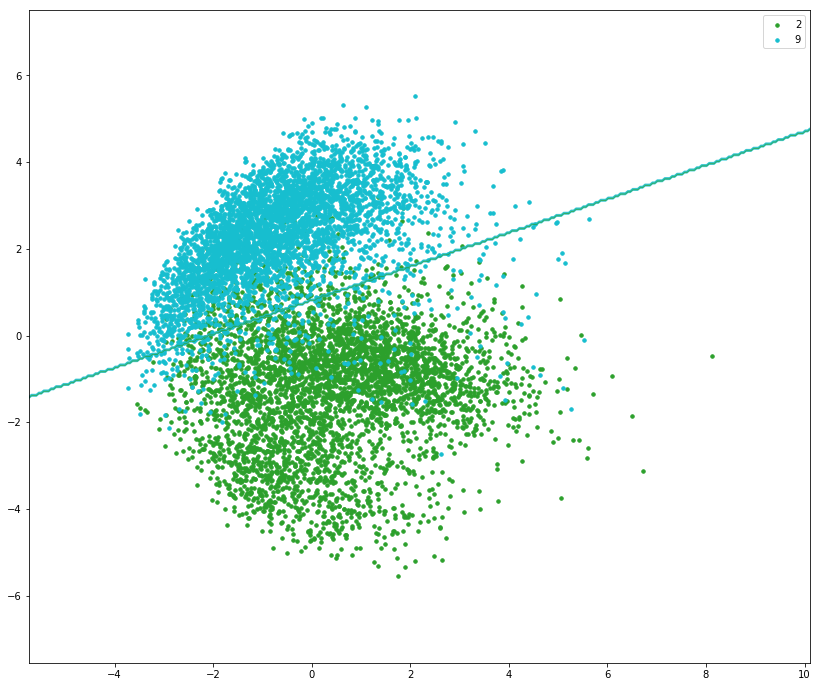

In [294]:
# Visualising Linear decision boundary

plt.figure(figsize = (14, 12))

h = 0.05
# create a mesh to plot in
x_min, x_max = pcaTrainImages[idx, 0].min() - 2, pcaTrainImages[idx, 0].max() + 2
y_min, y_max = pcaTrainImages[idx, 1].min() - 2, pcaTrainImages[idx, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, 2, colors = (plt.cm.Vega10.colors[9], plt.cm.Vega10.colors[2]), alpha=0.8)
for i in [2, 9]:
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], c = plt.cm.Vega10.colors[i], label = i, s = 12)

#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title(titles[i])
plt.legend(loc = 'upper right')

plt.show()
plt.close()

In [295]:
# SVM of Class 2 vs Class 9 (RBF Kernel)

idx = (trainLabels == 2) | (trainLabels == 9)

starttime = datetime.now()

svc = svm.SVC(kernel = 'rbf')
svc.fit(pcaTrainImages[idx, :], trainLabels[idx])

endtime = datetime.now()
print("Total time to train: ", endtime - starttime)

Total time to train:  0:00:01.182956


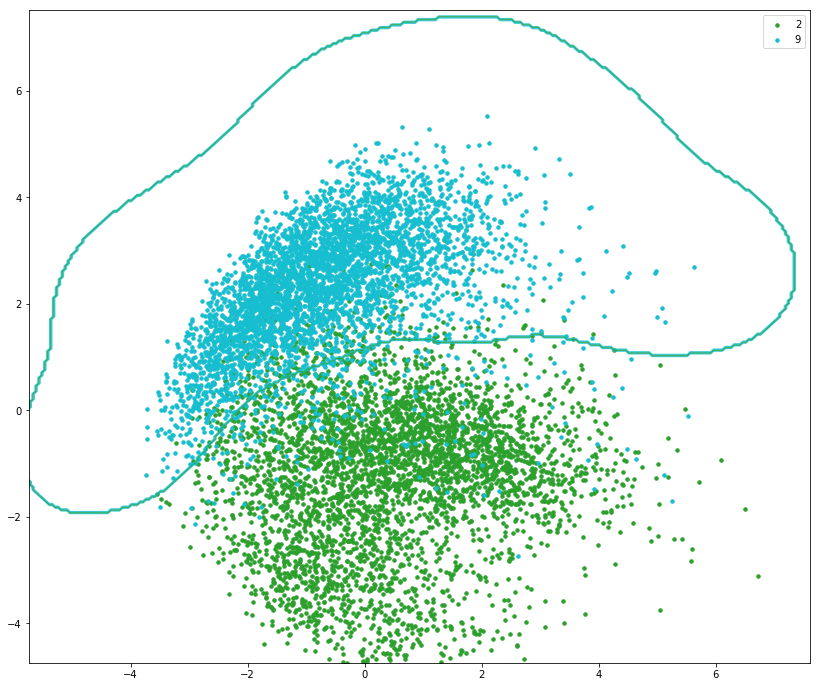

In [298]:
# Visualising non-Linear decision boundary

plt.figure(figsize = (14, 12))

h = 0.05
# create a mesh to plot in
x_min, x_max = pcaTrainImages[idx, 0].min() - 2, pcaTrainImages[idx, 0].max() + 2
y_min, y_max = pcaTrainImages[idx, 1].min() - 2, pcaTrainImages[idx, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, 2, colors = (plt.cm.Vega10.colors[9], plt.cm.Vega10.colors[2]), alpha=0.8)
for i in [2, 9]:
    idx = (trainLabels == i)
    plt.scatter(pcaTrainImages[idx, 0], pcaTrainImages[idx, 1], c = plt.cm.Vega10.colors[i], label = i, s = 12)

#plt.xlabel('Sepal length')
#plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title(titles[i])
plt.legend(loc = 'upper right')

plt.show()
plt.close()

#### (Neural Networks) Loss Value Decreases during Training Phase

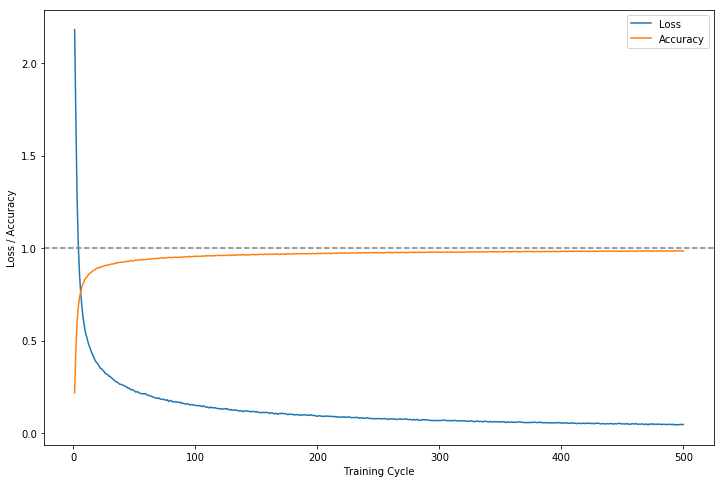

In [330]:
# Plot for MLP

MLPAcc = pd.read_csv('MLPPerf.csv')
plt.figure(figsize = (12, 8))
plt.plot(MLPAcc.index + 1, MLPAcc['loss'], label = 'Loss')
plt.plot(MLPAcc.index + 1, MLPAcc['acc'], label = 'Accuracy')

plt.axhline(1, color = 'grey', ls = 'dashed')
plt.xlabel("Training Cycle")
plt.ylabel("Loss / Accuracy (In-Sample)")
plt.legend(loc = "upper right")
plt.show()
plt.close()

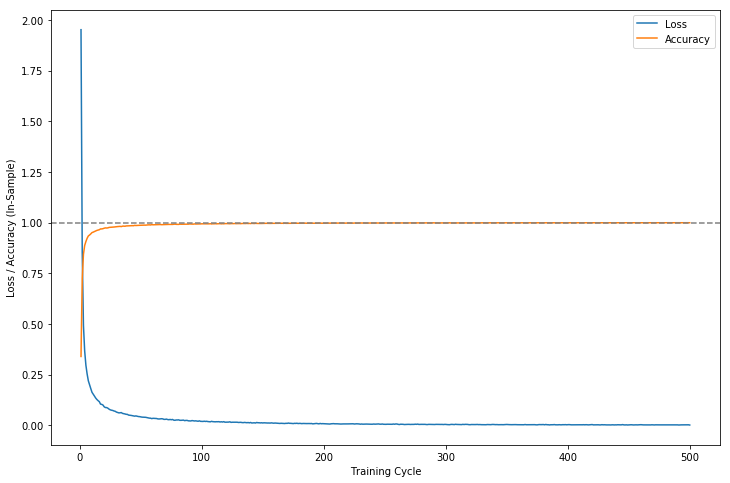

In [332]:
# Plot for CNN

CNNAcc = pd.read_csv('CNNPerf.csv')
plt.figure(figsize = (12, 8))
plt.plot(CNNAcc.index + 1, CNNAcc['loss'], label = 'Loss')
plt.plot(CNNAcc.index + 1, CNNAcc['acc'], label = 'Accuracy')

plt.axhline(1, color = 'grey', ls = 'dashed')
plt.xlabel("Training Cycle")
plt.ylabel("Loss / Accuracy (In-Sample)")
plt.legend(loc = "upper right")
plt.show()
plt.close()

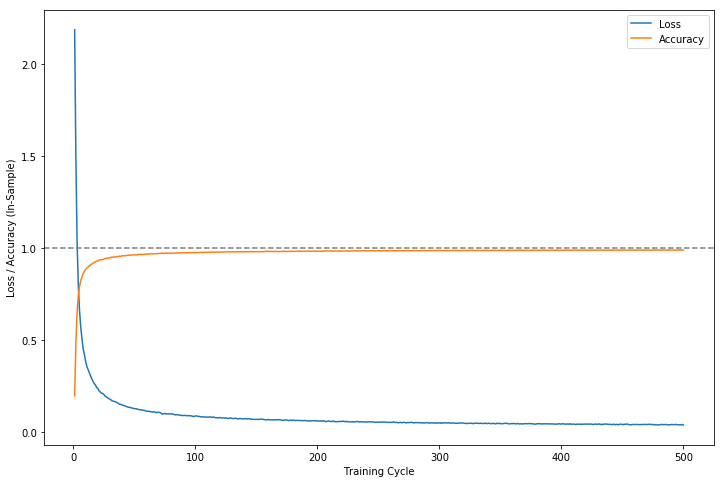

In [333]:
# Plot for CNN (with new training data created by convolving and shifting training images)

CNNNewAcc = pd.read_csv('CNNNewTrainingPerf.csv')
plt.figure(figsize = (12, 8))
plt.plot(CNNNewAcc.index + 1, CNNNewAcc['loss'], label = 'Loss')
plt.plot(CNNNewAcc.index + 1, CNNNewAcc['acc'], label = 'Accuracy')

plt.axhline(1, color = 'grey', ls = 'dashed')
plt.xlabel("Training Cycle")
plt.ylabel("Loss / Accuracy (In-Sample)")
plt.legend(loc = "upper right")
plt.show()
plt.close()

#### Create More Training Images by Convolving and Shifting Images

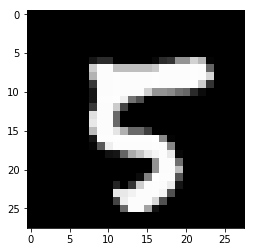

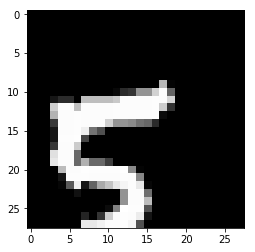

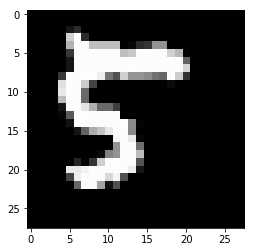

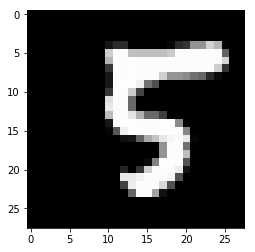

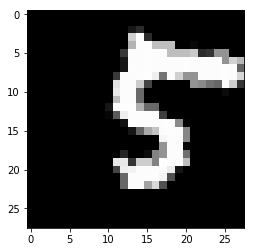

In [25]:
# Create 5 new example images using an image from training set

datagen = ImageDataGenerator(rotation_range = 20, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')

img = trainImages[1104]
lbl = trainLabels[1104]
img = img.reshape((1, 28, 28, 1))

plt.imshow(img.reshape((28, 28)), cmap = 'gray')
plt.show()
plt.close()

i = 1
for batch in datagen.flow(img, batch_size=1):
    plt.imshow(batch.reshape((28, 28)), cmap='gray')
    plt.show()
    plt.close()
    i += 1
    if i > 4:
        break  # otherwise the generator would loop indefinitely

### Mean of Train Images

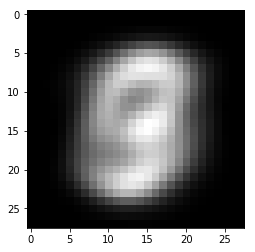

In [81]:
# Visualise the mean of all training images
img = np.mean(trainImages, axis = 0).reshape((28, 28))
plt.imshow(img, cmap='gray')
plt.show()
plt.close()